<font color="#04B404"><h1 align="center">ML</h1></font>
<font color="#6E6E6E"><h2 align="center">Diamonds dataset</h2></font>
<br>
<span>In this notebook we analyse a well-known dataset in ml: diamonds price's dataset (https://www.kaggle.com/shivam2503/diamonds?select=diamonds.csv). For that we use basic ml python tools such as pandas, numpy and sklearn.</span>

In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import pearsonr

In [3]:
# Importing data
data = pd.read_csv('./data/diamonds.csv')

In [4]:
# Sneak peek to data
display(data.head(5))
print(data.shape)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


(53940, 11)


### <font color="#CA3532">Data audit & preprocessing</font>

In [5]:
data = data.drop(['Unnamed: 0'], axis = 1)
data.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

In [6]:
# Numeric features
data.describe(include = 'object')

,cut,color,clarity
count,53940,53940,53940
unique,5,7,8
top,Ideal,G,SI1
freq,21551,11292,13065


In [7]:
# Categoric features
data.describe(include = 'number')

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


We observe that we have 3 categorical features and 7 numerical ones. Price feature is target.
Features x, y and z have min values of 0.0, which can't be possible. Let's see if there are many patterns with that value:

In [8]:
len(data[(data['x']==0) | (data['y']==0) | (data['z']==0)])

20

Which are very few data: we drop those patterns:

In [9]:
for var in ['x', 'y', 'z']:
    data.drop(data[data[var] == 0].index, axis=0, inplace=True)

In [10]:
# Missing values
for feature in data.columns:
    if data[feature].isnull().any():
        print('{0} has {1} null values.'.format(feature, data[feature].isnull().sum()))

So we have no missing values.

Visualizing data:

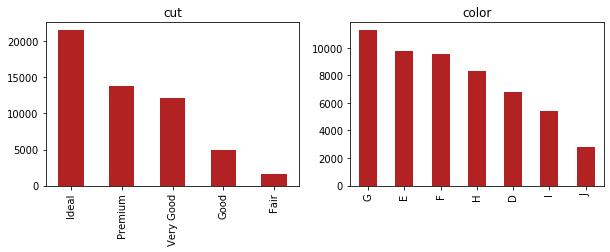

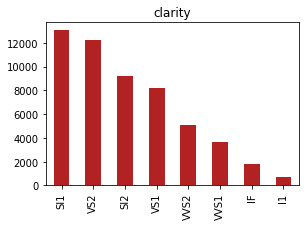

In [12]:
# Histograms for categorical data:
categorical_data = data.loc[:, data.dtypes == object]

for index, var in enumerate(categorical_data.columns):
    if index%2 == 0:
        plt.figure(figsize=(10,3))
    plt.subplot(1,2,index%2+1)
    p = categorical_data[var].value_counts().plot(kind = 'bar', color='firebrick', title = var)
    if index%2 == 1:
        plt.show() 

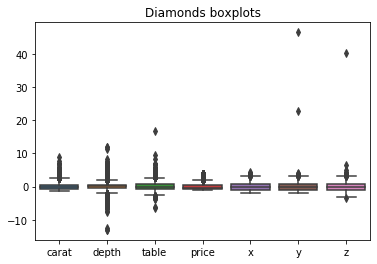

In [14]:
# Boxplots and histograms/scatterplots for numeric data
# Normalizing numerical data over z-scoring
numerical_data = data.loc[:, data.dtypes != object]
data_norm = (numerical_data - numerical_data.mean())/numerical_data.std()

bx_plot = sns.boxplot(data=data_norm)
# bx_plot = sns.boxplot(data=data)
plt.title('Diamonds boxplots')
plt.show()

So it seems that all features have outliers: let's see how many for each non-target feature:


In [15]:
is_outlier = np.abs(numerical_data - numerical_data.mean()) > 3.0*numerical_data.std()
for feature in numerical_data.columns:
    print('{0}: {1} outliers, {2:2.2f} % of total points'.format(feature, is_outlier[feature].sum(), 
                                                         is_outlier[feature].sum()/numerical_data.shape[0]))

carat: 436 outliers, 0.01 % of total points
depth: 685 outliers, 0.01 % of total points
table: 335 outliers, 0.01 % of total points
price: 1206 outliers, 0.02 % of total points
x: 35 outliers, 0.00 % of total points
y: 27 outliers, 0.00 % of total points
z: 36 outliers, 0.00 % of total points


As outliers points don't suppose more than 1% of points in any feature we decide to remove them: we will have to evaluate if this decision affects the model built (on justification of removing outliers: https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba, https://www.theanalysisfactor.com/outliers-to-drop-or-not-to-drop/)

In [16]:
numerical_data = numerical_data[~is_outlier.any(axis = 1)]
numerical_data.shape

# data[var][is_outlier[var]] = data[var][is_outlier[var]].clip(var_mean-3*var_std,
#                                                              var_mean+3*var_std)

(51586, 7)

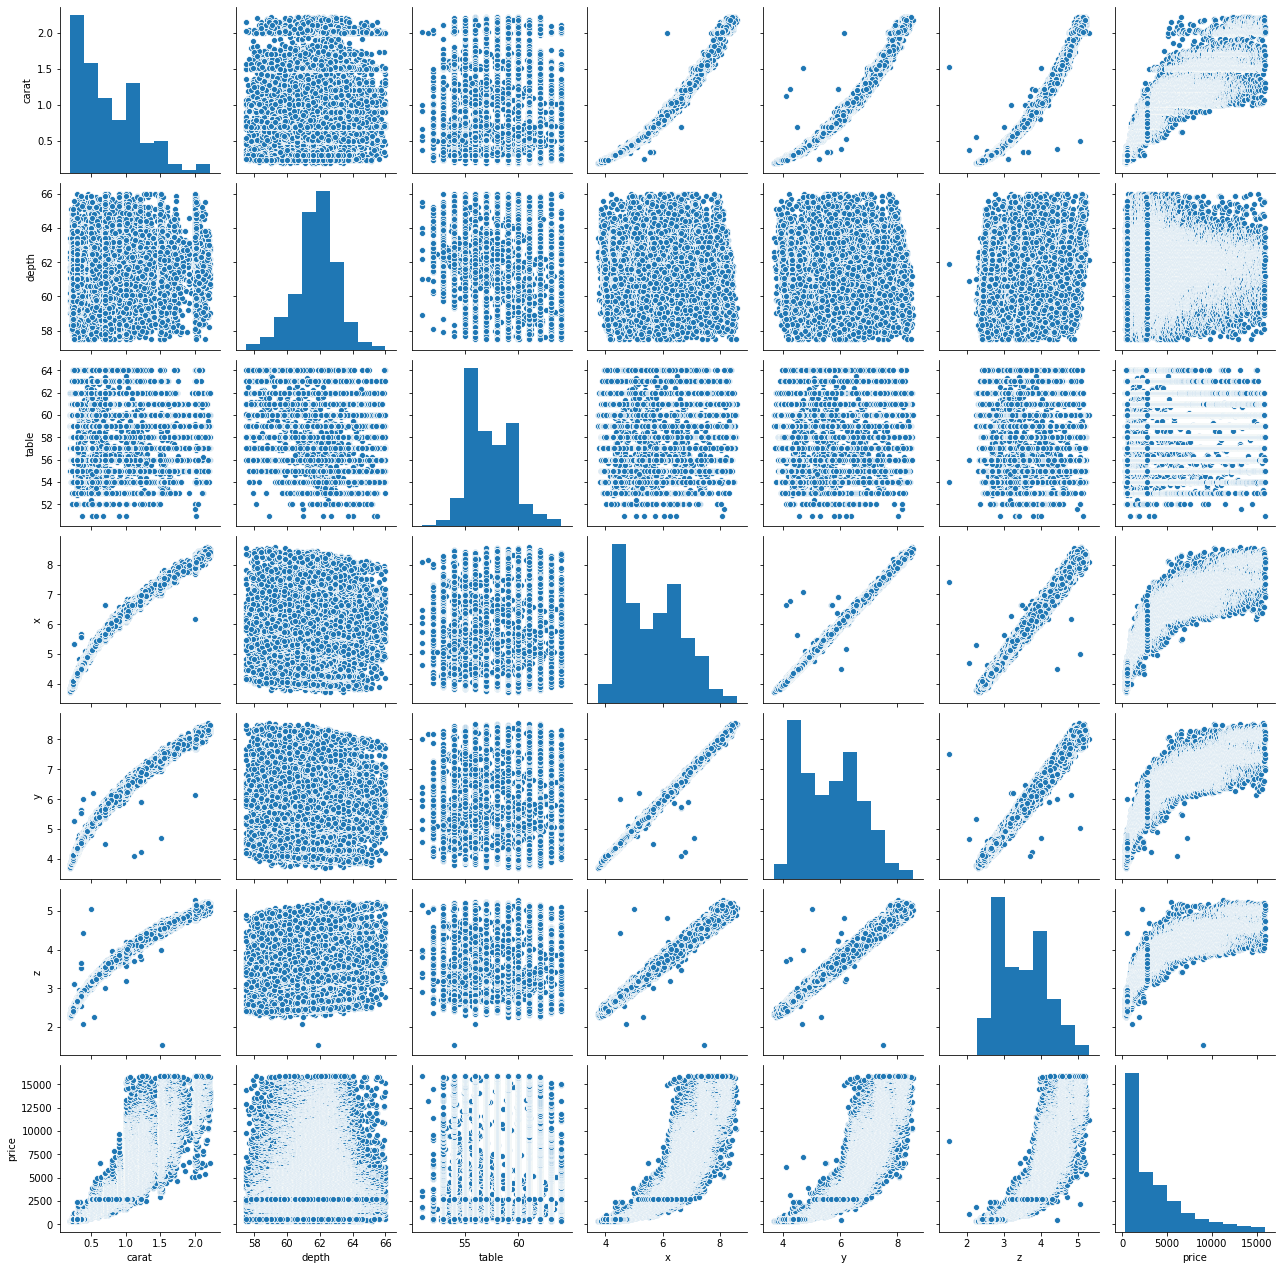

In [17]:
# Scatterplots
vars_diamonds = ['carat', 'depth', 'table', 'x', 'y', 'z']
target_diamonds = ['price']

num_vars_to_show = 6
pair_plot = sns.pairplot( numerical_data[vars_diamonds[:num_vars_to_show] + target_diamonds] )
plt.show()

On these plots:
* Target 'price' has a marked right tail.
* Dimension features 'x', 'y' and 'z' has a clear correlation with target: greater diamonds will cost more, obvious so far.
* Carat is the other feature with clear relationship with diamonds' price.

To observe correlation quantified we better draw a heatmap:

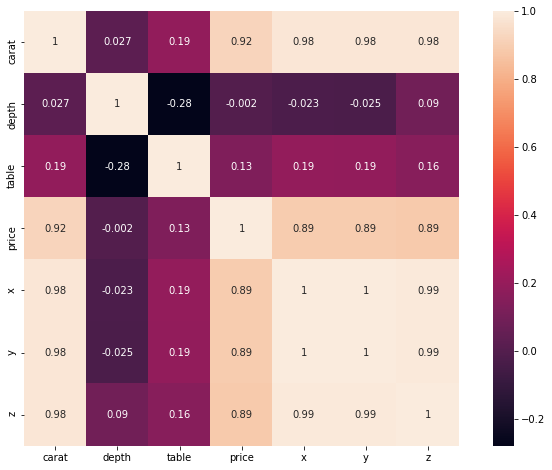

In [136]:
# Correlation Map
plt.figure(figsize=(12,8))
sns.heatmap(data=numerical_data.corr(), square=True , annot=True, cbar=True)
plt.show()

Heatmap confirm previous observations: x, y, z and carat are highly correlated with target 'price':

In [18]:
# for feature in ['x', 'y', 'z', 'carat']:
#     plt.scatter(x=numerical_data[feature], y=numerical_data['price'])
#     plt.xlabel(feature, fontsize=12)
#     plt.ylabel('price', fontsize=12)
#     plt.title('Pearson r: {:.2f}'.format(pearsonr(data[feature], data['price'])[0]), fontsize=12)
        
#     plt.show()

We create artificial variable 'volume' as a product of 'x', 'y' and 'z':

In [19]:
numerical_data['volume'] = numerical_data['x']*numerical_data['y']*numerical_data['z']
numerical_data

,carat,depth,table,price,x,y,z,volume
0,0.23,61.5,55.0,326,3.95,3.98,2.43,38.202030
1,0.21,59.8,61.0,326,3.89,3.84,2.31,34.505856
3,0.29,62.4,58.0,334,4.20,4.23,2.63,46.724580
4,0.31,63.3,58.0,335,4.34,4.35,2.75,51.917250
5,0.24,62.8,57.0,336,3.94,3.96,2.48,38.693952
...,...,...,...,...,...,...,...,...
53935,0.72,60.8,57.0,2757,5.75,5.76,3.50,115.920000
53936,0.72,63.1,55.0,2757,5.69,5.75,3.61,118.110175
53937,0.70,62.8,60.0,2757,5.66,5.68,3.56,114.449728
53938,0.86,61.0,58.0,2757,6.15,6.12,3.74,140.766120


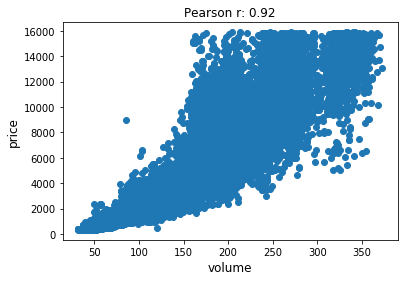

In [20]:
plt.scatter(x=numerical_data['volume'], y=numerical_data['price'])
plt.xlabel('volume', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.title('Pearson r: {:.2f}'.format(pearsonr(numerical_data['volume'], numerical_data['price'])[0]), fontsize=12)
        
plt.show()

Which seems to have a linear relationship with target and collect info of three 'x', 'y' and 'z' variables. Then we can drop them:

In [21]:
numerical_data.drop(['x', 'y', 'z'], axis=1, inplace=True) 

In [22]:
numerical_data.head()

,carat,depth,table,price,volume
0,0.23,61.5,55.0,326,38.202030
1,0.21,59.8,61.0,326,34.505856
3,0.29,62.4,58.0,334,46.724580
4,0.31,63.3,58.0,335,51.917250
5,0.24,62.8,57.0,336,38.693952


In [23]:
# Reconstruct original data with numerical transformed data and categorical
numerical_data.shape

(51586, 5)

In [24]:
categorical_data.shape

(53920, 3)

In [27]:
data = numerical_data.join(categorical_data, how='inner')
data.shape

(51586, 8)

In [28]:
# One hot encoding categorical features
for feature in ['cut', 'color', 'clarity']:
    dummies = pd.get_dummies(data[feature])
    data = pd.merge(data, dummies, left_index = True, right_index = True)
    

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51586 entries, 0 to 53939
Data columns (total 28 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   carat      51586 non-null  float64
 1   depth      51586 non-null  float64
 2   table      51586 non-null  float64
 3   price      51586 non-null  int64  
 4   volume     51586 non-null  float64
 5   cut        51586 non-null  object 
 6   color      51586 non-null  object 
 7   clarity    51586 non-null  object 
 8   Fair       51586 non-null  uint8  
 9   Good       51586 non-null  uint8  
 10  Ideal      51586 non-null  uint8  
 11  Premium    51586 non-null  uint8  
 12  Very Good  51586 non-null  uint8  
 13  D          51586 non-null  uint8  
 14  E          51586 non-null  uint8  
 15  F          51586 non-null  uint8  
 16  G          51586 non-null  uint8  
 17  H          51586 non-null  uint8  
 18  I          51586 non-null  uint8  
 19  J          51586 non-null  uint8  
 20  I1    